In [4]:
# !pip install spacy
# !python -m spacy download en_core_web_lg # WARNING about 400 mb
# !pip install scikit-learn

# !pip install umap-learn
# !pip install networkx

In [5]:
import sys

import spacy
from sklearn.cluster import DBSCAN
# from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

sys.path.append("..")
from src.make_data import get_long_text_summary


sys.tracebacklimit = 0 # easier to see problems


# Load the spaCy model
nlp = spacy.load("en_core_web_lg")

df = pd.read_csv("..//data/raw/the_zebra_movie_data.csv")

print(df.shape)


(5043, 26)


In [6]:



def cluster_words(words, eps=0.5, min_samples=2):
    """
    Groups words by semantic similarity using spaCy vectors and DBSCAN clustering.
    
    Args:
        words (list of str): List of words or short phrases to cluster.
        eps (float): DBSCAN epsilon parameter (maximum distance for a cluster).
        min_samples (int): DBSCAN min_samples parameter (minimum words per cluster).
        
    Returns:
        pd.DataFrame: DataFrame with words and their assigned cluster.
    """
    # Create spaCy vectors for each word
    vectors = np.array([nlp(word).vector for word in words])
    
    # Normalize vectors to unit length (optional but often helpful)
    vectors = np.nan_to_num(vectors)  # Handle NaNs in case of OOV words
    
    # Compute DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(vectors)
    
    # Assign clusters to words
    cluster_labels = clustering.labels_
    
    # Create a DataFrame for easy inspection
    clustered_df = pd.DataFrame({"Word": words, "Cluster": cluster_labels})
    return clustered_df

# Example usage
words = ["apple", "banana", "fruit", "dog", "cat", "animal", "car", "vehicle", "bike", "bus"]
result = cluster_words(words, eps=0.3, min_samples=2)
print(result)

# noisy samples given -1


      Word  Cluster
0    apple       -1
1   banana       -1
2    fruit       -1
3      dog        0
4      cat        0
5   animal       -1
6      car        1
7  vehicle        1
8     bike       -1
9      bus       -1


In [7]:
text = get_long_text_summary(df, "plot_keywords").reset_index(names = "keyword")

text

,keyword,n,num_voted,movie_score,movie_score_median
0,wrongful imprisonment,1,1689764.0,9.3,9.3
1,prison cell search,1,1689764.0,9.3,9.3
2,rise to power,1,1155770.0,9.2,9.2
3,moral challenge,2,12590.5,9.1,9.1
4,meaning of life,2,12590.5,9.1,9.1
...,...,...,...,...,...
8081,science experiment,1,25371.0,1.9,1.9
8082,cnn reporter,1,534.0,1.9,1.9
8083,pun,1,4377.0,1.7,1.7
8084,boyhood friend,1,74351.0,1.6,1.6


In [ ]:
import spacy
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
# Example data
data = {
    "movie_title": ["The Lion King", "The Jungle Book", "Finding Nemo", "Finding Dory", "Toy Story"],
    "Keywords": [
        "lion, africa, family, adventure",
        "jungle, animals, family, adventure",
        "ocean, fish, family, comedy",
        "fish, ocean, family, friendship",
        "toys, adventure, friendship, comedy"
    ],
    "gross": [1000, 800, 950, 1200, 1100]
}
df = pd.DataFrame(data)

df

,movie_title,Keywords,gross
0,The Lion King,"lion, africa, family, adventure",1000
1,The Jungle Book,"jungle, animals, family, adventure",800
2,Finding Nemo,"ocean, fish, family, comedy",950
3,Finding Dory,"fish, ocean, family, friendship",1200
4,Toy Story,"toys, adventure, friendship, comedy",1100


In [83]:
df = pd.read_csv("..//data/raw/the_zebra_movie_data.csv")

df["Keywords"] = df["plot_keywords"].str.replace("|", ",")
df = df.loc[df["Keywords"].notnull(), :]

# df["movie_title"] = df["movie_title"].fillna("NAN")
df = df.loc[df["movie_title"].notnull(), :]

df = df.loc[df["gross"].notnull(),:]
df["gross"] = np.log(df["gross"])

df

,color,director_name,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,Keywords
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,20.449494,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,"avatar,future,marine,native,paraplegic"
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,19.550159,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,"goddess,marriage ceremony,marriage proposal,pi..."
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,19.114199,Action|Adventure|Thriller,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,"bomb,espionage,sequel,spy,terrorist"
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,19.920595,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,"deception,imprisonment,lawlessness,police offi..."
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,18.106773,Action|Adventure|Sci-Fi,...,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,"alien,american civil war,male nipple,mars,prin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,12.959280,Drama|Sci-Fi|Thriller,...,English,USA,PG-13,7000.0,2004.0,45.0,7.0,1.85,19000,"changing the future,independent film,invention..."
5034,Color,Neill Dela Llana,35.0,80.0,0.0,0.0,Edgar Tancangco,0.0,11.157264,Thriller,...,English,Philippines,Not Rated,7000.0,2005.0,0.0,6.3,NaN,74,"jihad,mindanao,philippines,security guard,squa..."
5035,Color,Robert Rodriguez,56.0,81.0,0.0,6.0,Peter Marquardt,121.0,14.528911,Action|Crime|Drama|Romance|Thriller,...,Spanish,USA,R,7000.0,1992.0,20.0,6.9,1.37,0,"assassin,death,guitar,gun,mariachi"
5037,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,8.430327,Comedy|Drama,...,English,USA,Not Rated,9000.0,2011.0,205.0,6.4,NaN,413,written and directed by cast member


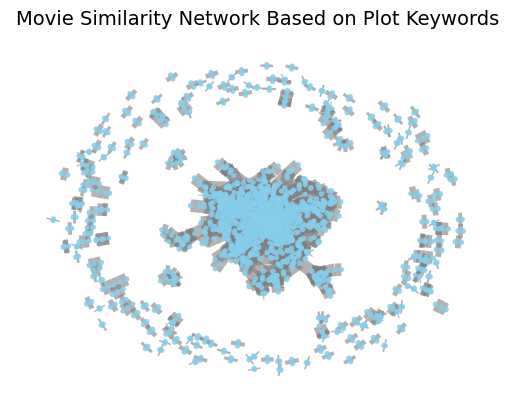

In [89]:

# Load spaCy model
nlp = spacy.load("en_core_web_lg")

# Generate embeddings for keywords
df["Vector"] = df["Keywords"].apply(lambda x: nlp(x).vector)

# Calculate cosine similarity matrix
vectors = np.stack(df["Vector"].values)
similarity_matrix = cosine_similarity(vectors)

# Build a graph
G = nx.Graph()

# Add nodes with gross income as size
for i, row in df.iterrows():
    G.add_node(row["movie_title"], size=row["gross"])

# Add edges for pairs with high similarity
threshold = 0.90  # Define similarity threshold
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        try:
            if similarity_matrix[i, j] > threshold:
                G.add_edge(df.loc[i, "movie_title"], df.loc[j, "movie_title"], weight=similarity_matrix[i, j])
        except KeyError:
            continue

# Remove nodes without edges
nodes_without_edges = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(nodes_without_edges)

# Visualize the graph
pos = nx.spring_layout(G)  # Layout for visualization

# Draw nodes, sizes based on gross income
node_sizes = [G.nodes[node]["size"] * 0.5 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)

# Draw edges, thickness based on similarity
edges = G.edges(data=True)
weights = [edge[2]["weight"] * 10 for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6, edge_color="gray")

# Draw labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Add title
plt.title("Movie Similarity Network Based on Plot Keywords", fontsize=14)
plt.axis("off")
plt.show()


In [95]:
# !pip install holoviews bokeh

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
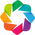

In [94]:
import holoviews as hv

hv.extension('bokeh')
# hv.Graph.from_networkx(G, nx.layout.spring_layout).opts(tools=['hover'])

In [29]:
# Importing required libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import umap
# from sklearn.datasets import make_blobs

# # Generate synthetic data
# n_samples = 1000
# n_features = 50
# n_clusters = 5
# data, labels = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
# data_tsne = tsne.fit_transform(data)

# # Apply UMAP
# umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# data_umap = umap_reducer.fit_transform(data)

# # Plotting
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# # t-SNE Plot
# axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', s=10)
# axes[0].set_title("t-SNE Visualization")
# axes[0].set_xlabel("Component 1")
# axes[0].set_ylabel("Component 2")

# # UMAP Plot
# axes[1].scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='tab10', s=10)
# axes[1].set_title("UMAP Visualization")
# axes[1].set_xlabel("Component 1")
# axes[1].set_ylabel("Component 2")

# plt.tight_layout()
# plt.show()
